In [34]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np

#These 3 things allow for some prettier graphs, using a different visualization package - seaborn.
#This isn't required, we'll start using this a little bit as we go. Seaborn's big selling point
#is that it allows us to create many common graphs, that are very nice, relatively easily
#The third line just makes the default plot size larger, you can change the numbers if you want. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,5)

In [ ]:
#Example of a seaborn distpolot - a histogram with a PDF overlayed on it. I use it in the solution.
#In this example, the data is the first argument, the other two arguments are sets of "customizations" for the histogram and PDF (KDE) part.
#You can use this, if you want, just change the data, and the labels and it should be usable for everything here.
#There are more options and examples detailed here: https://seaborn.pydata.org/generated/seaborn.distplot.html

#sns.distplot(dtGlen["Assessed Value"], hist_kws={"label":"Condos"}, kde_kws={"label":"Condo PDF"},)
#sns.distplot(glen["Assessed Value"], hist_kws={"label":"Glenora Garage"}, kde_kws={"label":"Glenora Garage PDF"},)
#plt.show()

In [46]:
#This function does the same work as the one we made last time - it does 6 graphs all in bulk: Hist, PMF, CDF, PDF, normal and lognormal prob plots. 
#One addition is the rnd=0 thing. That's how we can make one of those optional paramaters, if you don't provide anything there, the hist will have no
#rounding; if you provide a number, the histogram will round to that many digits. 
def bigGraph(df_in, columnName, rnd=0):
    data = pd.Series(df_in[columnName])
    hist = thinkstats2.Hist(round(data, rnd))
    pmf = thinkstats2.Pmf(data)
    cdf = thinkstats2.Cdf(data)
    thinkplot.PrePlot(6, rows =2, cols=3)
    thinkplot.Hist(hist)
    thinkplot.SubPlot(2)
    thinkplot.Pmf(pmf)
    thinkplot.SubPlot(3)
    thinkplot.Cdf(cdf)
    thinkplot.SubPlot(4)
    thinkstats2.NormalProbabilityPlot(data)
    thinkplot.SubPlot(5)
    thinkstats2.NormalProbabilityPlot(np.log(data))
    thinkplot.SubPlot(6)
    pdf = thinkstats2.EstimatedPdf(data)
    thinkplot.Pdf(pdf)
    thinkplot.Config()
    return

In [90]:
#Load data - I used the odd varaible name because I want the final name to be "df" after I do any filtering, so it is easier. 
df_init = pd.read_csv("Assessments.csv")

Revisit the Property Assessment data. We are looking for some info on home prices - we want to narrow our search to a specific subset of homes.

Our hypothesis is that over time, prices in Edmonton will rise. If we can invest in a segment of the market that is undervalued, that segment will rise faster as it "catches up" with the rest. We don't know if this hypothesis is true in reality - in the future we could do some predictive modelling to try to test it. We are going with a HIPPO opinion - low valued segments will rise, so that is what we will look for in our data. 

We also are smaller investors. We don't have the up front cash to purchase big money properties and "swing for the fences", we would very much prefer to target properties that are relatively less expensive, to allow us to purchase more and diversify the risk. 

So, our goal is to identify which segments of real estate have values that are suitable for investment, based on our assumptions.  
(Note: There are differnt potential answers - I find a set of homes that may look good based on our criteria, there's probably others, it is not a yes/no answer)

Use: Attempt to break down and examine the data to find some property groups that appear to be solid investments, supported by the data you have. You can follow my example, or go your own way. There's probably many potential groups that make sense. The solution version has everything I did. 

Part 1: Preview data and make sure the data present is what we want/need. 

In [21]:
df_init.head()

,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude
0,1066158,NaN,14904.0,167 AVENUE NW,N,NaN,NaN,NaN,86000,53.630497,-113.580474
1,10508233,NaN,16340.0,MARK MESSIER TRAIL NW,N,NaN,NaN,NaN,45000,53.617335,-113.605690
2,1194398,NaN,15617.0,83 STREET NW,N,2050.0,BELLE RIVE,Ward 3,285000,53.617007,-113.467976
3,1034214,NaN,10661.0,161 AVENUE NW,Y,3040.0,BEAUMARIS,Ward 3,635000,53.619978,-113.506990
4,1114701,NaN,15003.0,76 AVENUE NW,Y,4430.0,RIO TERRACE,Ward 5,407500,53.508644,-113.579897


In [22]:
df_init.describe(include="all")

,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude
count,3.842170e+05,80043,342008.000000,342008,384217,384213.000000,384213,384213,3.842170e+05,384217.000000,384217.000000
unique,NaN,1899,NaN,2765,2,NaN,345,12,NaN,NaN,NaN
top,NaN,202,NaN,104 STREET NW,Y,NaN,OLIVER,Ward 9,NaN,NaN,NaN
freq,NaN,979,NaN,2034,235286,NaN,11380,51837,NaN,NaN,NaN
mean,7.813424e+06,NaN,7663.119035,NaN,NaN,4270.033703,NaN,NaN,3.084198e+05,53.518421,-113.512491
std,3.232763e+06,NaN,5439.436817,NaN,NaN,1748.172894,NaN,NaN,2.837778e+05,0.068403,0.082829
min,1.001163e+06,NaN,1.000000,NaN,NaN,1010.000000,NaN,NaN,0.000000e+00,53.338595,-113.712930
25%,4.584405e+06,NaN,2504.000000,NaN,NaN,2660.000000,NaN,NaN,1.700000e+05,53.458619,-113.569078
50%,9.966988e+06,NaN,7916.000000,NaN,NaN,4540.000000,NaN,NaN,3.055000e+05,53.519813,-113.510520
75%,1.017294e+07,NaN,11425.000000,NaN,NaN,5576.000000,NaN,NaN,3.975000e+05,53.574187,-113.447708


We are looking for houses. There's a bunch of data here for houses that are both insanely cheap - near 0, or insanely expensive. We aren't big money investors, so I think the properties over $1mill are not relevant to our examination. 

We don't want that stuff because, for our purposes, it isn't usefull, so we'll remove it - leaving us with only homes that cost a "normal" amount. 

In [91]:
df = df_init[df_init["Assessed Value"] > 50000]
df = df[df["Assessed Value"] < 1000000]
df.describe(include="all")

,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude
count,3.339850e+05,79257,333750.000000,333750,333985,333982.000000,333982,333982,333985.000000,333985.000000,333985.000000
unique,NaN,1638,NaN,2726,2,NaN,340,12,NaN,NaN,NaN
top,NaN,202,NaN,104 STREET NW,Y,NaN,OLIVER,Ward 9,NaN,NaN,NaN
freq,NaN,976,NaN,2021,231275,NaN,7472,42306,NaN,NaN,NaN
mean,7.606939e+06,NaN,7709.258511,NaN,NaN,4309.295447,NaN,NaN,332817.712382,53.519205,-113.510951
std,3.273373e+06,NaN,5432.207688,NaN,NaN,1722.380669,NaN,NaN,150520.220473,0.069117,0.083632
min,1.001346e+06,NaN,1.000000,NaN,NaN,1010.000000,NaN,NaN,50500.000000,53.338595,-113.712930
25%,4.232054e+06,NaN,2538.000000,NaN,NaN,2700.000000,NaN,NaN,227000.000000,53.459043,-113.569350
50%,9.479718e+06,NaN,8004.000000,NaN,NaN,4520.000000,NaN,NaN,323500.000000,53.519458,-113.508079
75%,1.013107e+07,NaN,11439.000000,NaN,NaN,5590.000000,NaN,NaN,408500.000000,53.577400,-113.444329


About 50,000 properties removed. Seems reasonable. We can look at the distribution and see what is there...

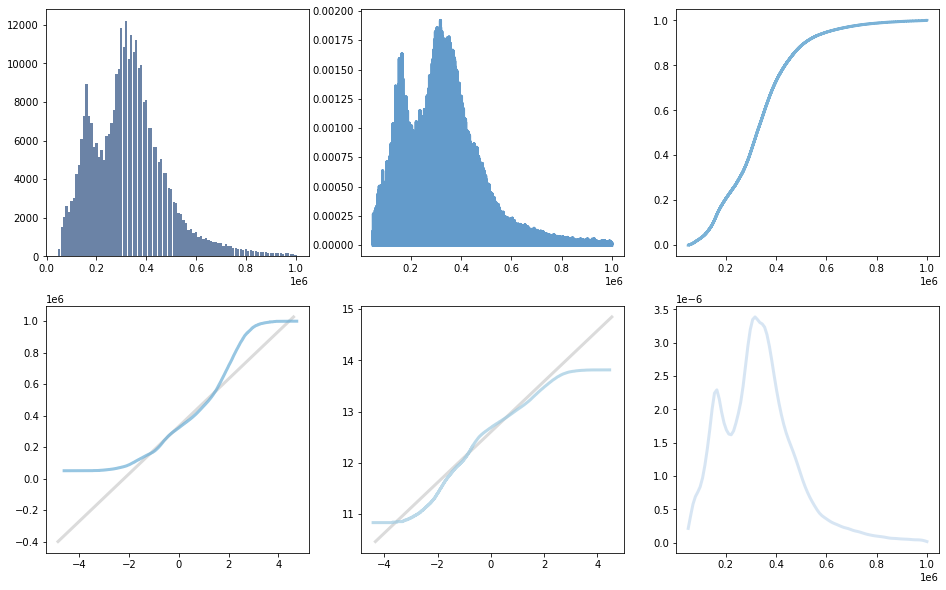

In [28]:
bigGraph(df, "Assessed Value", -4)

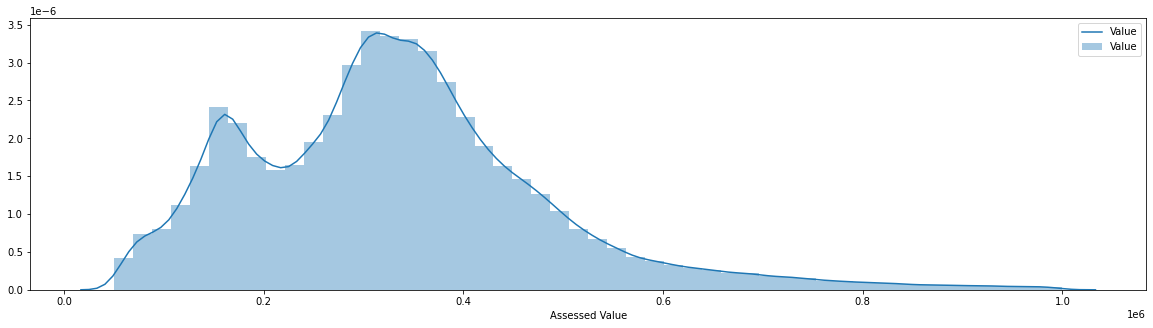

In [101]:
#Fancy plot
sns.distplot(df["Assessed Value"], kde_kws={"label":"Value"}, hist_kws={"label":"Value"})
plt.show()

We have taken a look at the statistics and the distribution of the data. Can we draw any conclusions from what we've seen here? 

Part 2: Split the data, to look for tendencies by groups. We have several values we can use, I will start with the most simple - garage. 

In [30]:
#Create two dataframes, one for each garage class. 
glen = df[df["Garage"]=="Y"]
df_no = df[df["Garage"]=="N"]

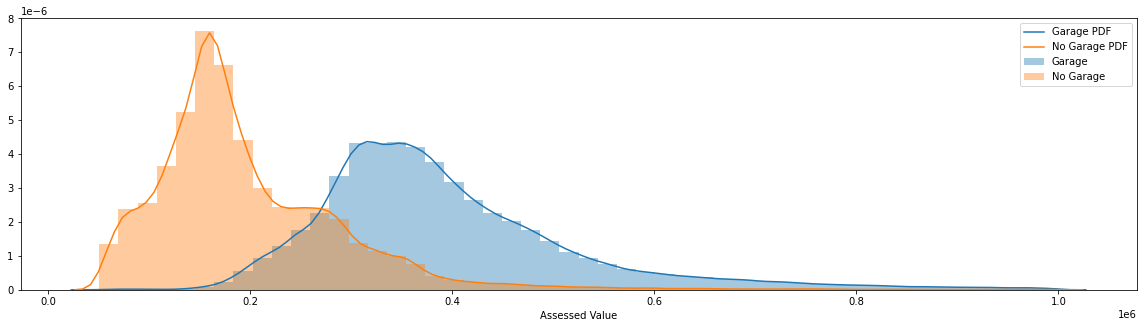

In [38]:
#Plot the garage/non-garage distributions. 
sns.distplot(df_gar["Assessed Value"], kde_kws={"label":"Garage PDF"}, hist_kws={"label":"Garage"})
sns.distplot(df_no["Assessed Value"], kde_kws={"label":"No Garage PDF"}, hist_kws={"label":"No Garage"})
plt.show()

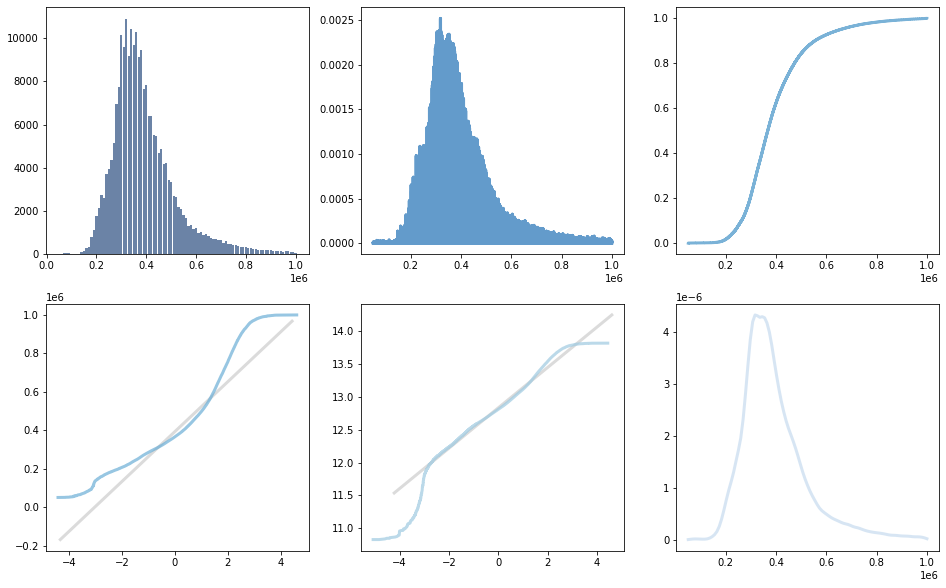

In [48]:
bigGraph(df_gar, "Assessed Value", -4)

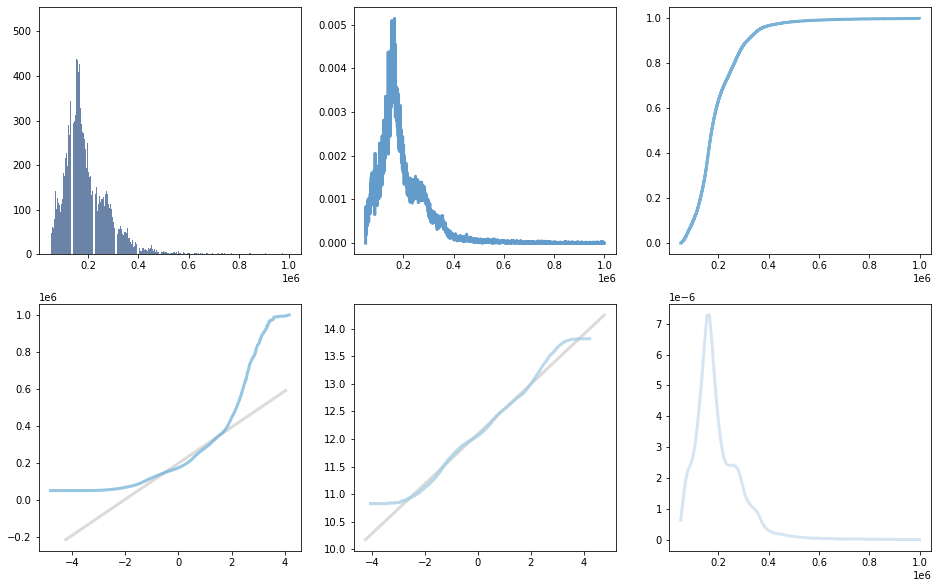

In [49]:
bigGraph(df_no, "Assessed Value")

We can see that both of our slices of data, once separated, are much closer to a normal distribution. Analyzing these two separately is probably going to be easier than the double bump original distribution. 
I will caclulate a bunch of statistics for each group - including skew, so I can get a measure of how "stretched out" the distribution is. 

I will also look at each group and figure out what share of the homes are less than $200k, $350k, and $500k, for my own info - if I want to invest in properties that are "lowish" in value, how many are there?

In [50]:
print("Garage - Mean:", df_gar["Assessed Value"].mean(), "Median:", df_gar["Assessed Value"].median(), "STD:", df_gar["Assessed Value"].std(), "Skew:", thinkstats2.Skewness(df_gar["Assessed Value"]))
print("Non-Garage - Mean:", df_no["Assessed Value"].mean(), "Median:", df_no["Assessed Value"].median(), "STD:", df_no["Assessed Value"].std(), "Skew:", thinkstats2.Skewness(df_no["Assessed Value"]))

Garage - Mean: 392847.61504702194 Median: 366500.0 STD: 129514.19777661306 Skew: 1.4131815384478883
Non-Garage - Mean: 197646.6897088891 Median: 173500.0 STD: 97552.29499596237 Skew: 2.104894051798442


In [103]:
#Use CDF to figure out 
cdfg1 = thinkstats2.Cdf(df_gar["Assessed Value"])
cdfn1 = thinkstats2.Cdf(df_no["Assessed Value"])
print("Garage - <200:", cdfg1.Prob(200000), "<350:", cdfg1.Prob(350000), "<500:", cdfg1.Prob(500000))
print("No Garage - <200:", cdfn1.Prob(200000), "<350:", cdfn1.Prob(350000), "<500:", cdfn1.Prob(500000))

Garage - <200: 0.017243541238784996 <350: 0.4302756458761215 <500: 0.8449594638417468
No Garage - <200: 0.6341446791938468 <350: 0.9392756304157336 <500: 0.985668386719891


What can we make of this? A few things, we aren't entirely sure if they will be important right now.

- Non garage houses are about $200k cheaper on average.

- Non garage houses are more tightly packed (smaller std), more "peaky" (kurtosis), and trail off to the right more (skew). This should kind of make sense logically, there's lots of smaller and cheaper nonm-garage homes, then there are a handful of luxury properties that scatter around the higher values. We can hypothesize that many/most non-garage houses are condos, but we need to check it. Houses over a certain, relatively low, value tend to always have garages so there's less weirdness to the distribution. 

- There is a comparatively massive cache of non-garage homes that are under $200k, and almost all are under $350k

In [60]:
#Use suite values to assess house/condo split. My assumption is that if a home has a Suite number, it is a condo; if it doesn't, it is a house.
#If I calculate that percentage for each group, it could help indicate if my guess is true:
print("Garage:", df_gar["Suite"].isnull().sum()/len(df_gar["Suite"]))
print("Non:", df_no["Suite"].isnull().sum()/len(df_no["Suite"]))

Garage: 0.93769322235434
Non: 0.3686398597994353


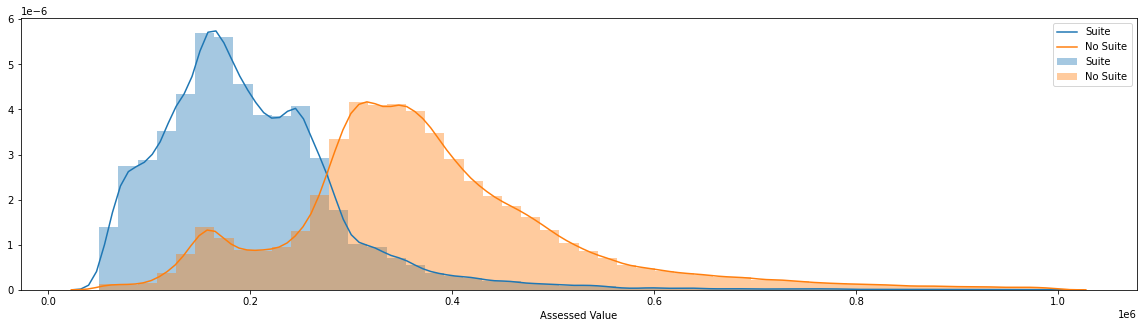

In [105]:
#Graph the suite/nonsuite groups against eachother. 
df_s = df[df["Suite"].notnull()]
df_n = df[df["Suite"].isnull()]
sns.distplot(df_s["Assessed Value"], kde_kws={"label":"Suite"}, hist_kws={"label":"Suite"})
sns.distplot(df_n["Assessed Value"], kde_kws={"label":"No Suite"}, hist_kws={"label":"No Suite"})
plt.show()

I think my hypothesis is supported - non garage houses mostly do have a suite number, garage ones mainly don't. This isn't a 100% definitive result, but it is pretty solid. 

What can we take from this? Condos are cheaper, houses are more expensive. Garage is an OK-ish proxy for the house/condo split, not at all perfect - I also suspect it is probably a stronger relationship as prices rise, I doubt many expensive houses don't have garages. 

As well, perhaps as the city grows and as it becomes more dense and urban, perhaps the value of condos will rise and become closer to homes. We see a pattern of central condos becomming more expensive in most larger cities, a hypothesis that a similar thing will happen here is pretty reasonable. 


NOTE: At this point, we could also/alternatively split the data into suite/non-suite segments, or a 4 way split with both suite and garage. I will continue with garage/non for now. In real life, there's a pretty high probability that we'd come back and also split the data by suite. 

Part 4: Investigate location. 

To investigate this more, we need to take a look at where these properties are located.... We can see what data we have - Ward, neighborhood, and lat/lon all indicate position. I need to go look at a map to see what is useful. Wards are large, and there are 12 of them. Neigborhoods are small, and there are a lot. We can start with wards and do a crude split for initial investigation. 

In [62]:
#How many properties are in each ward? 
df_no["Ward"].value_counts()

Ward 6     19028
Ward 9     10826
Ward 4      9798
Ward 1      8652
Ward 11     8392
Ward 10     8282
Ward 12     8058
Ward 8      6693
Ward 5      6599
Ward 2      6364
Ward 7      5098
Ward 3      4917
Name: Ward, dtype: int64

On a map, Ward 6 is downtown, it has the most non garage properties, which makes sense. 9 is Riverbend, there's lots of condos in Terwilligar and area. 4 is the far north east, 1 is the north-west, 11 is near south-east, 10 is Calgary Trail and west, 12 is far south east, and 8 is Strathcona and east to the city limit. 

First try, we can isolate downtown from the surroundings.

In [74]:
#Create new dataframe for Ward 6, and everything else from the non-garage set of homes.
dt = df_no[df_no["Ward"] == "Ward 6"]
burb = df_no[df_no["Ward"]!= "Ward 6"]


,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude
10,1286483,910,10145.0,121 STREET NW,N,1150.0,OLIVER,Ward 6,120500,53.542162,-113.530183
18,1213032,1701,11826.0,100 AVENUE NW,N,1150.0,OLIVER,Ward 6,808500,53.539950,-113.526293
72,1286657,909,10145.0,121 STREET NW,N,1150.0,OLIVER,Ward 6,146000,53.542162,-113.530183
90,1030782,40,10160.0,119 STREET NW,N,1150.0,OLIVER,Ward 6,191000,53.542264,-113.527347
97,1244110,103,10917.0,109 STREET NW,N,1030.0,CENTRAL MCDOUGALL,Ward 6,86500,53.555105,-113.507884


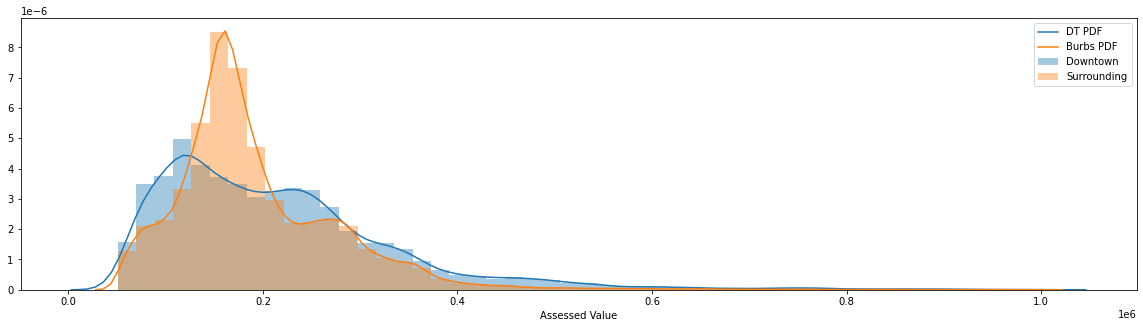

In [76]:
#Plot the new groupings. 
sns.distplot(dt["Assessed Value"], hist_kws={"label":"Downtown"}, kde_kws={"label":"DT PDF"},)
sns.distplot(burb["Assessed Value"], hist_kws={"label":"Surrounding"}, kde_kws={"label":"Burbs PDF"},)
plt.show()

Bingo, bango, we may have found what we are looking for! Our downtown condos have a peak that is lower than the surrounding areas (probably largely because they are older). With our above hypothesis, we can draw some conclusions. The distribution is a little bimodal, that might require some more in depth investigation. I suspect that the lower bump are properties on the beltline of central Edmonton, but we need to investigate to be sure. 

If central areas become more valuable as cities grow and densify, then looking at investing in downtown, non-garage properties may make some sense. They appear to be undervalued here compared to other subsets of property. 

This also gives us some evidence that the prices of our non-garage condos are not "capped". They follow a normalish distribution, so we shouldn't expect that their price hits a ceiling if we renovate or as areas gentrify. 

In [80]:
dtcCDF = thinkstats2.Cdf(dt["Assessed Value"])
bcCDF = thinkstats2.Cdf(burb["Assessed Value"])
allCDF = thinkstats2.Cdf(df["Assessed Value"])

In [106]:
#What percent of homes are 'cheap' in our different groups?
dtcCDF.Prob(150000), bcCDF.Prob(150000), allCDF.Prob(150000)

(0.358629388269918, 0.31251643125164313, 0.10016318098118179)

Part 5: Investigate the location data a little further - examine what neighborhood these homes fall into. 

In [83]:
#How many homes are in each hood?
dt["Neighbourhood"].value_counts()

OLIVER               7369
DOWNTOWN             5058
QUEEN MARY PARK      1785
WESTMOUNT            1379
BOYLE STREET         1237
CENTRAL MCDOUGALL     801
RIVERDALE             394
GLENORA               352
MCCAULEY              286
GROVENOR              156
ROSSDALE              139
MCQUEEN                45
NORTH GLENORA          27
Name: Neighbourhood, dtype: int64

In [86]:
#What is the average value of each set of hood's homes?
dt.groupby("Neighbourhood").mean().sort_values("Assessed Value")

,Account Number,House Number,Neighbourhood ID,Assessed Value,Latitude,Longitude
Neighbourhood,,,,,,
CENTRAL MCDOUGALL,7.499017e+06,10669.605053,1030.0,119441.323346,53.552918,-113.501849
BOYLE STREET,8.002838e+06,9520.632983,1020.0,132987.469685,53.550640,-113.476803
MCQUEEN,7.960693e+06,11584.355556,3300.0,141611.111111,53.557475,-113.576634
QUEEN MARY PARK,7.593352e+06,10851.211204,1180.0,161319.327731,53.550726,-113.520516
GLENORA,4.303697e+06,13542.107955,3200.0,195035.511364,53.544147,-113.561376
WESTMOUNT,8.663235e+06,10800.078229,3440.0,206397.751994,53.550981,-113.535642
OLIVER,5.490062e+06,10433.576083,1150.0,217471.977202,53.540943,-113.520753
MCCAULEY,5.270428e+06,10178.985612,1140.0,217816.433566,53.555625,-113.485285
DOWNTOWN,8.360574e+06,10109.853895,1090.0,257635.429023,53.540528,-113.501037


In [89]:
#Combo (sort of) view of the above tables. 
dt.groupby("Neighbourhood").count().sort_values("Assessed Value")

,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude
Neighbourhood,,,,,,,,,,
NORTH GLENORA,27,0,27,27,27,27,27,27,27,27
MCQUEEN,45,33,45,45,45,45,45,45,45,45
ROSSDALE,139,116,139,139,139,139,139,139,139,139
GROVENOR,156,36,156,156,156,156,156,156,156,156
MCCAULEY,286,20,278,278,286,286,286,286,286,286
GLENORA,352,297,352,352,352,352,352,352,352,352
RIVERDALE,394,284,394,394,394,394,394,394,394,394
CENTRAL MCDOUGALL,801,719,752,752,801,801,801,801,801,801
BOYLE STREET,1237,1209,1237,1237,1237,1237,1237,1237,1237,1237


Part 6: Look at one potential area - Glenora. There are a non trivial number of homes, and it appears that there are several homes that are "underpriced" compared to what we may typically expect. 

If there are cheap non-garage homes in a very nice and generally expensive hood, we might think that if we were to improve these homes and/or wait for the city to grow and densify, that the value of these homes may "catch up" to other homes in the area. Many people want to live in Glenora, but the large houses are appreciating away from the affordability of more and more people. This isn't a fact, it is a pretty reasonable hypothesis. If you have ever heard the saying "buy the worst house on the block", it follows the same logic - location matters over anythig else. 

In [96]:
#Extract the glenora homes into their own dataframe
dtGlen = dt[dt["Neighbourhood"]=="GLENORA"]

In [98]:
#Create dataframe with all the garaged homes in Glenora, so we can compare. 
glen = df[(df["Neighbourhood"]=="GLENORA") & (df["Garage"] == "Y")]
glen["Assessed Value"].mean()
#glen.head()

642533.7142857143

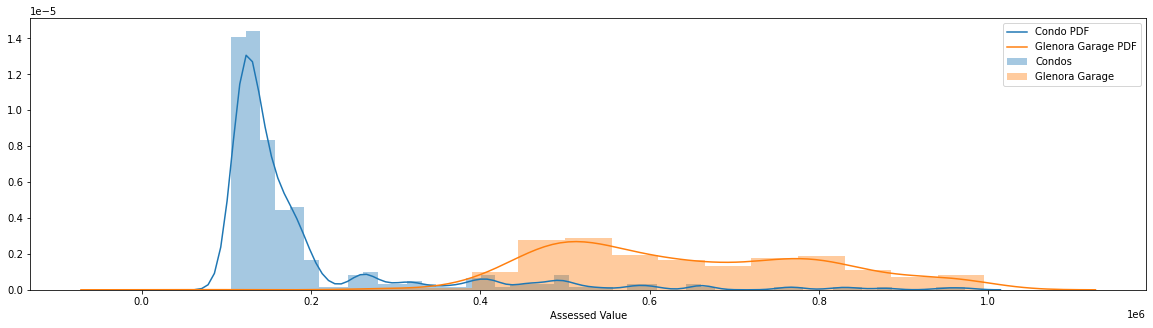

In [100]:
#Plot Glenora's homes - garage vs none.
sns.distplot(dtGlen["Assessed Value"], hist_kws={"label":"Condos"}, kde_kws={"label":"Condo PDF"},)
sns.distplot(glen["Assessed Value"], hist_kws={"label":"Glenora Garage"}, kde_kws={"label":"Glenora Garage PDF"},)
plt.show()

In [108]:
#Take the satistics:
print("Glenora - Mean:", glen["Assessed Value"].mean(), "Median:", glen["Assessed Value"].median(), "STD:", glen["Assessed Value"].std(), "Skew:", thinkstats2.Skewness(df_gar["Assessed Value"]))
print("Non-Gar. Glen - Mean:", dtGlen["Assessed Value"].mean(), "Median:", dtGlen["Assessed Value"].median(), "STD:", dtGlen["Assessed Value"].std(), "Skew:", thinkstats2.Skewness(dtGlen["Assessed Value"]))

Glenora - Mean: 642533.7142857143 Median: 616000.0 STD: 160094.8240731049 Skew: 1.4131815384478883
Non-Gar. Glen - Mean: 195035.51136363635 Median: 141500.0 STD: 144389.9467156847 Skew: 2.9031246230029835


So, where are we? We have a hood where there are a non-trivial number of garge free homes, where the value of those homes is drastically lower than the overall average price in that hood. We also have a handfull of examples of expensive condos in that hood. We know this area is centrally located.

From external knowledge, glenora is a desireable and wealthy hood overall. 

If we are going to look into actual investments, the limited dataset we have here supports us researching Glenora, specifically homes without garages in Glenora as a potential target. We can't be sure that this makes sense without going out anf getting more domain knowledge though - our data didn't have everything - square footage, building age, etc... that we'd need to put cash on the line. 